# Artificial Life Substrate Examples and Demo Code

In this notebook we are going to try and make some demo code which shows how different models of Artificial Life work and look at some nice visualisations.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# See animations in Jupyter notebooks
%matplotlib widget

## Conway's Game of Life

Conway's Game of Life is a cellular automaton where a grid of cells evolves through generations based on simple rules. Each cell can be alive (1) or dead (0), and its state in the next generation depends on its 8 neighbors:

1. A live cell **survives** if it has 2 or 3 neighbors; otherwise, it dies (under/overpopulation).  
2. A dead cell **comes to life** if it has exactly 3 neighbors.  

The rules lead to fascinating patterns and emergent behavior.

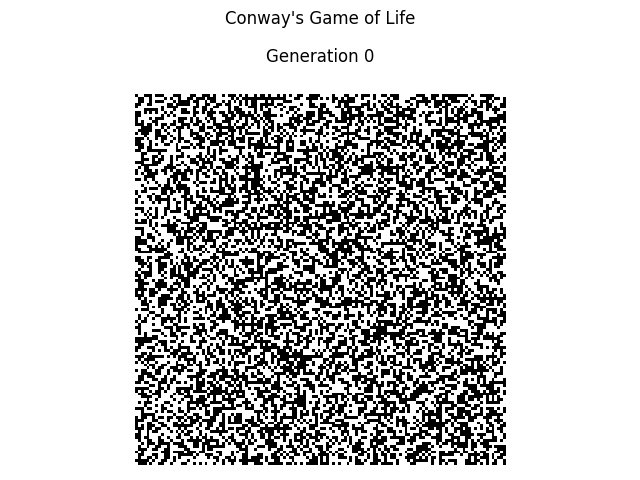

In [11]:
@jax.jit
def conway_step(state):
    """
    A single Conway's Game of Life update step.
    - state: 2D jnp.array of 0s and 1s.
    Returns the next generation (same shape as input).
    """
    neighbors = sum(
        jnp.roll(jnp.roll(state, i, axis=0), j, axis=1)
        for i in (-1, 0, 1)
        for j in (-1, 0, 1)
        if not (i == 0 and j == 0)
    )
    # Apply Conway's rules
    return jnp.where(
        (state == 1) & ((neighbors == 2) | (neighbors == 3)), 1,
        jnp.where((state == 0) & (neighbors == 3), 1, 0)
    )

def run_conway(size=64, steps=200, interval=10, random_seed=0):
    """
    Run Conway's Game of Life simulation with adjustable parameters.

    Args:
        size (int): The width/height of the (square) board.
        steps (int): Number of frames (generations) to animate (and then stop).
        interval (int): Delay between frames in milliseconds.
        random_seed (int): Seed for the random initialization.

    Returns:
        ani (matplotlib.animation.FuncAnimation): The animation object.
    """
    rng = jax.random.PRNGKey(random_seed)
    state = jax.random.randint(rng, (size, size), 0, 2)

    fig, ax = plt.subplots()
    fig.suptitle("Conway's Game of Life")
    mat = ax.matshow(state, cmap='binary')
    ax.set_axis_off()
    ax.set_title("Generation 0")
    fig.tight_layout()

    def update(frame):
        nonlocal state
        # Compute the next state
        state = conway_step(state)
        # Update the displayed image data
        mat.set_data(state)
        # Update title
        ax.set_title(f"Generation {frame + 1}")
        return [mat]

    ani = animation.FuncAnimation(
        fig, 
        update, 
        frames=steps,       # Run exactly `steps` frames
        interval=interval,  # Delay between frames in milliseconds
        blit=True,
        repeat=False        # Do not repeat once completed
    )
    return ani

# Example usage
anim = run_conway(size=128, steps=100)
plt.show()

## Boids

### Core Principles

Each **boid** $ i $ is defined by its position $ \mathbf{p}_i $ and velocity $ \mathbf{v}_i $ in 2D space. The movement is governed by three simple rules:

1. **Separation**: Avoid crowding neighbors.
   $$
   \mathbf{a}_{\text{sep}} = \sum_{j \neq i} \frac{\mathbf{p}_i - \mathbf{p}_j}{\|\mathbf{p}_i - \mathbf{p}_j\|^2} \cdot \mathbb{1}_{\|\mathbf{p}_i - \mathbf{p}_j\| < d_{\text{sep}}}
   $$

2. **Alignment**: Align velocity with neighbors.
   $$
   \mathbf{a}_{\text{ali}} = \frac{1}{|\mathcal{N}_{\text{ali}}|} \sum_{j \in \mathcal{N}_{\text{ali}}} \mathbf{v}_j - \mathbf{v}_i
   $$

3. **Cohesion**: Move towards the average position of neighbors.
   $$
   \mathbf{a}_{\text{coh}} = \frac{1}{|\mathcal{N}_{\text{coh}}|} \sum_{j \in \mathcal{N}_{\text{coh}}} \mathbf{p}_j - \mathbf{p}_i
   $$

### Velocity and Position Update

Combine accelerations and update velocity and position with constraints:
$$
\mathbf{v}_i \leftarrow \mathbf{v}_i + (\mathbf{a}_{\text{sep}} + \mathbf{a}_{\text{ali}} + \mathbf{a}_{\text{coh}})
$$
$$
\mathbf{v}_i \leftarrow \text{limit}(\mathbf{v}_i, v_{\text{max}})
$$
$$
\mathbf{p}_i \leftarrow \mathbf{p}_i + \mathbf{v}_i \mod \text{(boundary)}
$$

### Emergent Patterns

Simple local rules lead to complex group behaviors:
- **Flocking**: Cohesive movement in a unified direction.
- **Swarming**: Dense, dynamic clusters.
- **V-Formation**: Efficient directional travel.
- **Obstacle Avoidance**: Seamless navigation around barriers.

### Hyperparameter Effects

- **Separation Distance ($ d_{\text{sep}} $)**:
  - *Increase*: More dispersed flocks.
  - *Decrease*: Tighter groups, potential overlaps.
  
- **Neighbor Distances ($ d_{\text{ali}}, d_{\text{coh}} $)**:
  - *Increase*: Larger, more unified flocks.
  - *Decrease*: Smaller, fragmented groups.
  
- **Weights ($ w_{\text{sep}}, w_{\text{ali}}, w_{\text{coh}} $)**:
  - *Higher $ w_{\text{sep}} $*: Greater avoidance, more spread out.
  - *Higher $ w_{\text{ali}} $*: Smoother, aligned movement.
  - *Higher $ w_{\text{coh}} $*: Stronger group cohesion.
  
- **Maximum Velocity ($ v_{\text{max}} $) & Acceleration ($ a_{\text{max}} $)**:
  - *Increase $ v_{\text{max}} $*: Faster movement, more dynamic patterns.
  - *Decrease $ a_{\text{max}} $*: Smoother, more gradual changes.

The Boids algorithm elegantly demonstrates how simple, local interaction rules—**separation**, **alignment**, and **cohesion**—can produce sophisticated, lifelike flocking behaviors. By adjusting hyperparameters such as interaction distances and behavioral weights, one can control the density, unity, and responsiveness of the flock, enabling a wide range of emergent patterns.

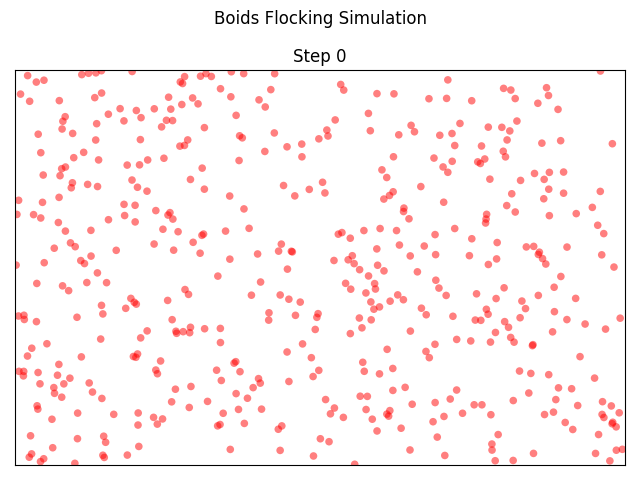

In [12]:
def limit_vector(vectors, limit):
    """
    Limit the magnitude (L2 norm) of each 2D vector in 'vectors' to 'limit'.
    """
    speeds = jnp.linalg.norm(vectors, axis=1, keepdims=True)
    scale = jnp.where(speeds > limit, limit / (speeds + 1e-8), 1.0)
    return vectors * scale

def normalize_nonzero(vectors):
    """
    Normalize each 2D vector unless its length is ~0, in which case it remains zero.
    """
    speeds = jnp.linalg.norm(vectors, axis=1, keepdims=True) + 1e-8
    return vectors / speeds

def initialize_boids(key, num_boids, params):
    """
    Initialize random positions (within width×height) and random velocities
    with magnitude up to max_velocity.
    """
    width, height = params["width"], params["height"]
    max_v = params["max_velocity"]

    subkey1, subkey2 = jax.random.split(key, 2)

    positions = jax.random.uniform(subkey1, shape=(num_boids, 2))
    positions = positions * jnp.array([width, height])  # scale to screen size

    angles = jax.random.uniform(subkey2, shape=(num_boids,)) * 2.0 * jnp.pi
    vx = jnp.cos(angles) * max_v
    vy = jnp.sin(angles) * max_v
    velocities = jnp.stack([vx, vy], axis=1)

    return positions, velocities


def separation(positions, velocities, params):
    """
    Steer to avoid crowding neighbors. 
    For each boid, compute a repulsive force away from boids that are
    within the 'separation_distance'.
    Logic mirrors the OOP code:
       diff = (self-pos_j).normalized()
       steer += diff/d
       then average & limit
    """
    dist_sep = params["separation_distance"]
    max_velocity = params["max_velocity"]
    max_acc = params["max_acceleration"]

    # pairwise displacements: shape (N, N, 2)
    disp = positions[:, None, :] - positions[None, :, :]  # i-j
    dist = jnp.linalg.norm(disp, axis=2)

    # boids that are within separation distance (and not itself)
    mask = (dist > 0.0) & (dist < dist_sep)

    # So the vector we add is disp / (dist^2).
    # We'll add a small epsilon to avoid 0 in the denominator.
    repulsion = disp / (dist[..., None] ** 2 + 1e-8)

    # Apply mask
    repulsion_masked = repulsion * mask[..., None]

    # Sum across neighbors
    steer = jnp.sum(repulsion_masked, axis=1)

    # Average by neighbor count
    counts = jnp.sum(mask, axis=1, keepdims=True)
    steer = jnp.where(counts > 0, steer / counts, steer)

    # Standard "Reynolds" approach: if steer>0, normalize -> desired -> minus velocity -> limit
    steer_norm = jnp.linalg.norm(steer, axis=1, keepdims=True)
    steer_unit = jnp.where(steer_norm > 0, steer / steer_norm, steer)
    steer_desired = steer_unit * max_velocity
    steer_final = steer_desired - velocities

    # Limit to max_acceleration
    steer_final = limit_vector(steer_final, max_acc)
    return steer_final


def alignment(positions, velocities, params):
    """
    For each boid, steer toward the average velocity of neighbors within
    alignment_distance.
    """
    neighbor_dist = params["alignment_distance"]
    max_velocity = params["max_velocity"]
    max_acc = params["max_acceleration"]

    disp = positions[:, None, :] - positions[None, :, :]
    dist = jnp.linalg.norm(disp, axis=2)

    mask = (dist > 0.0) & (dist < neighbor_dist)

    # sum velocities of neighbors
    sum_vels = jnp.sum(velocities[None, :, :] * mask[..., None], axis=1)
    counts = jnp.sum(mask, axis=1, keepdims=True)
    avg_vel = jnp.where(counts > 0, sum_vels / (counts + 1e-8), sum_vels)  # avoid /0

    # Reynolds: desired = normalized(avg_vel)*max_velocity
    steer_desired = normalize_nonzero(avg_vel) * max_velocity
    steer = steer_desired - velocities
    steer = limit_vector(steer, max_acc)

    return steer


def cohesion(positions, velocities, params):
    """
    For each boid, find the "center of mass" (average position) of neighbors,
    then 'seek' it.
    """
    neighbor_dist = params["cohesion_distance"]
    max_velocity = params["max_velocity"]
    max_acc = params["max_acceleration"]

    disp = positions[:, None, :] - positions[None, :, :]
    dist = jnp.linalg.norm(disp, axis=2)

    mask = (dist > 0.0) & (dist < neighbor_dist)

    sum_pos = jnp.sum(positions[None, :, :] * mask[..., None], axis=1)
    counts = jnp.sum(mask, axis=1, keepdims=True)
    center_of_mass = jnp.where(counts > 0, sum_pos / (counts + 1e-8), sum_pos)

    # "seek(center_of_mass)": desired = normalized(center_of_mass - self_pos)*max_velocity
    desired = normalize_nonzero(center_of_mass - positions) * max_velocity
    steer = desired - velocities
    steer = limit_vector(steer, max_acc)

    return steer


@jax.jit
def boids_step(positions, velocities, params):
    """
    One step of the Boids update. Given current positions and velocities, 
    returns updated positions and velocities.
    JIT-compiled by JAX for speed.
    """
    sep = separation(positions, velocities, params) * params["weight_separation"]
    ali = alignment(positions, velocities, params)   * params["weight_alignment"]
    coh = cohesion(positions, velocities, params)    * params["weight_cohesion"]

    accel = sep + ali + coh
    new_vel = velocities + accel
    new_vel = limit_vector(new_vel, params["max_velocity"])

    new_pos = positions + new_vel
    # Wrap boundaries (like borders() in OOP code)
    w, h = params["width"], params["height"]
    new_pos = jnp.mod(new_pos, jnp.array([w, h]))

    return new_pos, new_vel

def run_animation(num_boids=200, steps=1000, params=None):
    if params is None:
        # Just to match the code snippet from the OOP version:
        # https://www.labri.fr/perso/nrougier/from-python-to-numpy/code/boid_python.py
        params = {}
        params["width"] = 640
        params["height"] = 360
        params["max_velocity"] = 2.0
        params["max_acceleration"] = 0.03
        # Separation distance is smaller (25) than the alignment/cohesion distance (50):
        params["separation_distance"] = 25.0
        params["alignment_distance"] = 50.0
        params["cohesion_distance"] = 50.0
        # Force weights (Reynolds):
        params["weight_separation"] = 1.5
        params["weight_alignment"] = 1.0
        params["weight_cohesion"] = 1.0

    rng = jax.random.PRNGKey(0)
    positions, velocities = initialize_boids(rng, num_boids, params)

    fig, ax = plt.subplots()
    fig.suptitle("Boids Flocking Simulation")
    ax.set_xlim(0, params["width"])
    ax.set_ylim(0, params["height"])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Step 0")
    fig.tight_layout()

    scatter = ax.scatter(positions[:,0], positions[:,1],
                         s=30, facecolor="red", edgecolor="None", alpha=0.5)

    # We'll store the current state in a small dict for updating each frame
    state = {"pos": positions, "vel": velocities}

    def update(frame):
        new_p, new_v = boids_step(state["pos"], state["vel"], params)
        state["pos"], state["vel"] = new_p, new_v
        scatter.set_offsets(new_p)
        ax.set_title(f"Step {frame + 1}")
        return (scatter,)

    ani = animation.FuncAnimation(fig, update, interval=10, blit=True, frames=steps, repeat=False)
    plt.show()
    return ani

# Example usage
ani = run_animation(num_boids=500, steps=1000)

## Particle Life

## Lenia

## Neural Cellular Automata

## Flow Lenia

## Particle Lenia

## Neural Cellular Automata

## BioMaker CA

## JaxLife

## Evolved Virtual Creatures 

## Polyworld